In [145]:
import plotly as plotly
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv('data/modeled_data.csv', index_col=0)
y = df.pop('co2')
X = df.copy(deep=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [146]:
X.describe()

,num_employees,buildings,vehicles
count,1000.000000,1000.000000,1000.000000
mean,6523.638000,43.305000,238.509000
std,3668.251018,90.464146,293.118905
min,88.000000,0.000000,2.000000
25%,3649.750000,7.000000,63.750000
50%,6441.000000,14.000000,140.500000
75%,9045.750000,44.000000,294.750000
max,25527.000000,1454.000000,3262.000000


In [147]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real

import warnings

warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

pipe = Pipeline(steps=[("scaler", StandardScaler()), ("clf", LinearRegression())])
lr_search = {
    "clf": [LinearRegression()]
}
dt_search = {
    "clf": [DecisionTreeRegressor()],
    #     "clf__criterion": Categorical(["gini", "entropy"]),
    "clf__max_depth": Integer(2, 20),
    "clf__min_samples_leaf": Integer(2, 50),
}
rf_search = {
    "clf": [RandomForestRegressor()],
    #         "clf__criterion": Categorical(["squared_error", "gini"]),
    "clf__max_depth": Integer(2, 20),
    "clf__min_samples_leaf": Integer(2, 50),
},
lgbm_search = {

    "clf": [LGBMRegressor(objective='regression', metric='rmse', boosting_type='gbdt')],
    # "clf__num_leaves": Integer(1, 15),
    'clf__reg_sqrt': Categorical([True, False]),
    "clf__n_estimators": Integer(25, 3000),
    #     "clf__boosting_type": Categorical(["gbdt"]),
    'clf__learning_rate': Real(0.01, 0.5, prior='log-uniform'),
    'clf__max_depth': Integer(-1, 128),
    'clf__num_leaves': Integer(2, 512),
    #     'clf__feature_fraction': Real(0.1, 1.0, prior='uniform'),
    'clf__subsample': Real(0.1, 1.0, prior='uniform'),
    'clf__colsample_bytree': Real(0.01, 1.0, 'uniform'),  # Subsample ratio of columns when constructing each tree
    'clf__reg_lambda': Real(1e-9, 100.0, 'log-uniform'),  # L2 regularization
    'clf__reg_alpha': Real(1e-9, 100.0, 'log-uniform'),  # L1 regularization
}

opt = BayesSearchCV(pipe,
                    [
                        # (lgbm_search, 20),
                        # (lr_search, 1),
                        (dt_search, 20)
                    ],
                    cv=3,
                    scoring='r2',
                    verbose=0,
                    return_train_score=True,
                    n_jobs=-1
                    )

opt.fit(X_train, y_train)
!say done

In [148]:
columns = ['params', 'mean_test_score', 'mean_train_score', 'mean_fit_time', 'std_test_score']
cv_df = pd.DataFrame(opt.cv_results_).sort_values(by='rank_test_score')[columns].reset_index(drop=True)
cv_df = cv_df.join(cv_df.pop('params').apply(pd.Series))
cv_df.clf = cv_df.clf.apply(lambda x: x.__str__().split('(')[0].replace('Classifier', '')).astype("category")
cv_df.head(10)

,mean_test_score,mean_train_score,mean_fit_time,std_test_score,clf,clf__max_depth,clf__min_samples_leaf
0,0.788859,0.934803,0.002654,0.022128,DecisionTreeRegressor,19,2
1,0.788165,0.934803,0.003926,0.020464,DecisionTreeRegressor,20,2
2,0.788056,0.934780,0.002020,0.020700,DecisionTreeRegressor,14,2
3,0.787721,0.934799,0.003466,0.021302,DecisionTreeRegressor,15,2
4,0.787338,0.934803,0.003344,0.020914,DecisionTreeRegressor,20,2
5,0.787151,0.934803,0.003905,0.021226,DecisionTreeRegressor,20,2
6,0.786221,0.934780,0.001725,0.021799,DecisionTreeRegressor,14,2
7,0.785343,0.934803,0.002383,0.021637,DecisionTreeRegressor,17,2
8,0.785022,0.934780,0.002727,0.022468,DecisionTreeRegressor,14,2
9,0.784507,0.934803,0.006032,0.022650,DecisionTreeRegressor,20,2


In [149]:
import matplotlib.pyplot as plt

# print(plt.style.available)
plt.style.use('seaborn-v0_8-paper');

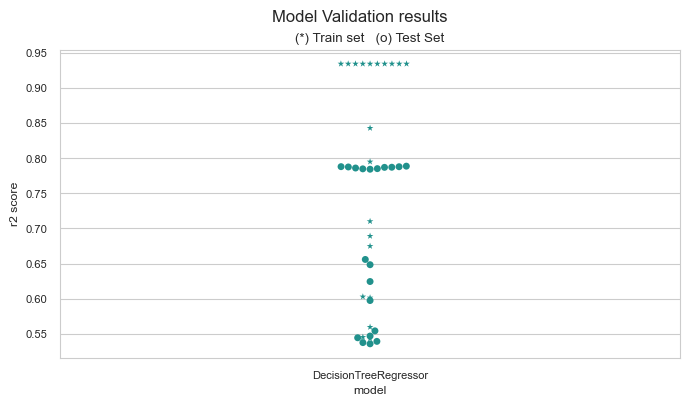

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
sns.swarmplot(x="clf", y="mean_test_score", data=cv_df, palette='viridis', hue='clf', ax=ax)
sns.swarmplot(x="clf", y="mean_train_score", data=cv_df, palette='viridis', hue='clf', marker='*', ax=ax)
plt.xlabel('model')
plt.ylabel('r2 score')
plt.suptitle('Model Validation results')
plt.title('(*) Train set   (o) Test Set');
ax.get_legend().remove()


In [151]:
opt.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeRegressor(max_depth=19, min_samples_leaf=2))])

In [152]:
model_arch = DecisionTreeRegressor(max_depth=20, min_samples_split=50)
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("clf", model_arch)])
pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeRegressor(max_depth=20, min_samples_split=50))])

In [153]:
pipe.score(X, y)

0.8720406380772899

# Save Model

In [154]:
import joblib

joblib.dump(pipe, 'model/best_model.pkl')

['model/best_model.pkl']

# Feature Importance

In [155]:
import shap

model = pipe.steps[-1][-1]
preprocessing = pipe.steps[0][-1]
X_transformed = preprocessing.transform(X_test)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_transformed)

In [156]:
feature_names = X.columns

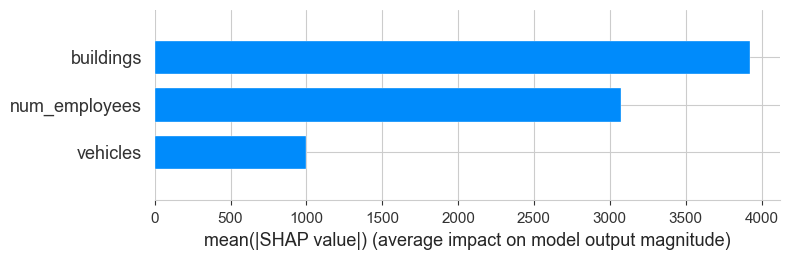

In [157]:
shap.summary_plot(shap_values, X_train, feature_names=feature_names, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


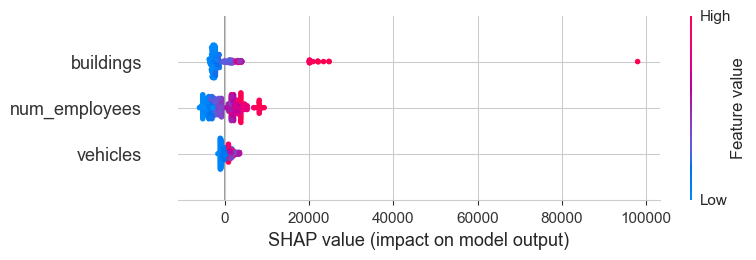

In [166]:
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

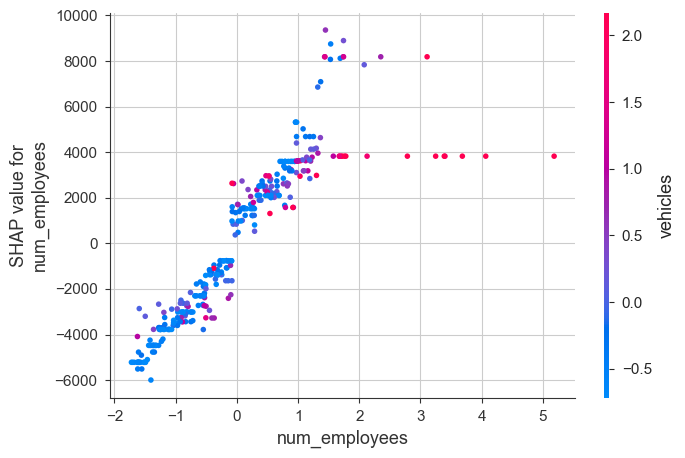

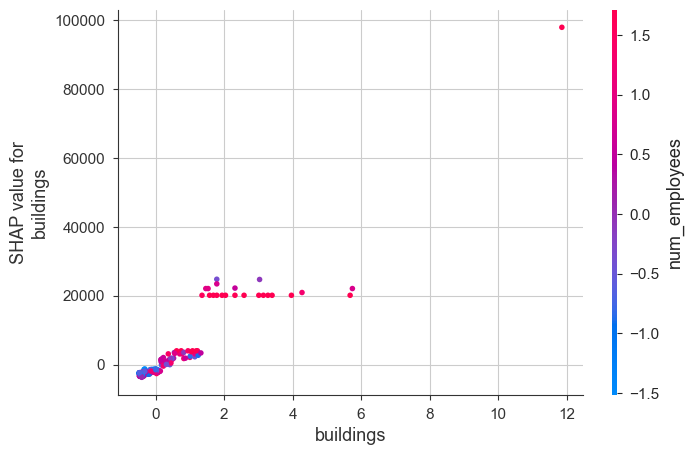

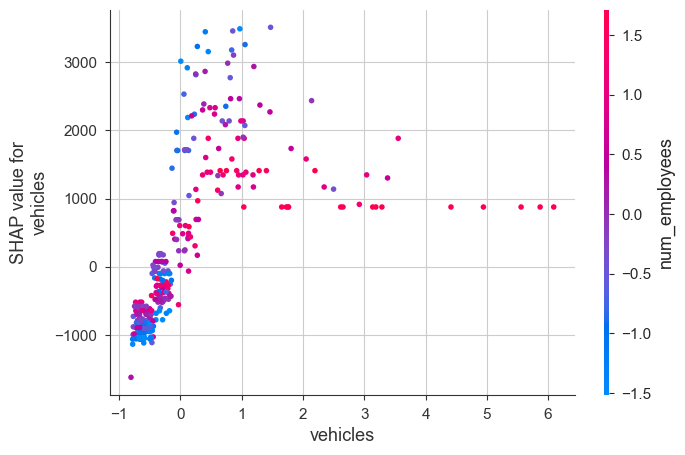

In [167]:
for i in range(len(feature_names)):
    shap.dependence_plot(i, shap_values, X_transformed, feature_names=feature_names)

In [168]:
X_test.iloc[18]

num_employees    3802
buildings           5
vehicles           88
Name: 761, dtype: int64

In [169]:
X_test.iloc[0]

num_employees    2971
buildings           3
vehicles          142
Name: 521, dtype: int64

In [176]:
input_data = pd.DataFrame([{
    'num_employees': 10_000,
    'buildings': 40,
    'vehicles': 100
}])


In [177]:
show_values = {}
show_values['num_employees'] = '{:,}'.format(input_data['num_employees'][0])
show_values['buildings'] = '{:,}'.format(input_data['buildings'][0])
show_values['vehicles'] = '{:,}'.format(input_data['vehicles'][0])
show_values = pd.DataFrame([show_values])

In [178]:
show_values

,num_employees,buildings,vehicles
0,"10,000",40,100


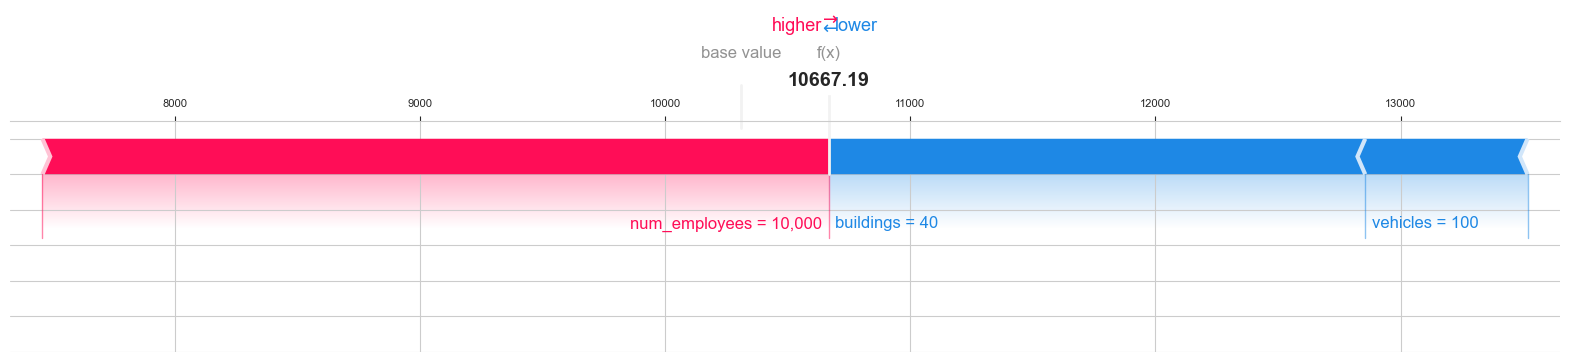

In [179]:
shap.initjs()
input_data_transformed = preprocessing.transform(input_data)
input_shap_values = explainer.shap_values(input_data_transformed)

shap.force_plot(explainer.expected_value, input_shap_values[0], show_values, feature_names = feature_names, matplotlib=True)

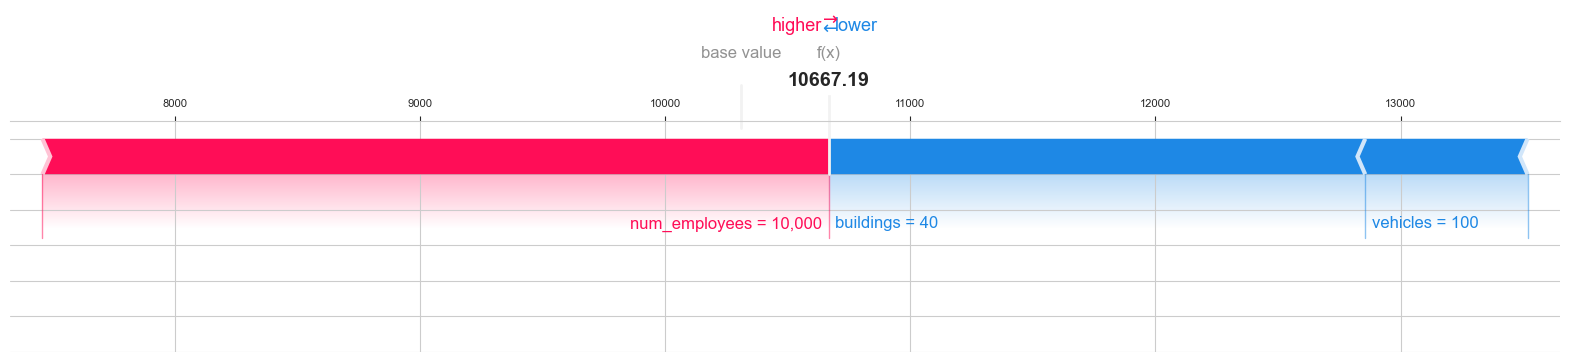

In [180]:
shap.force_plot(explainer.expected_value, input_shap_values[0], show_values, feature_names = feature_names, matplotlib=True)

In [195]:
explainer.expected_value, input_shap_values[0], show_values.values

(array([10309.64710663]),
 array([ 3208.34349574, -2188.50717957,  -662.29734722]),
 array([['10,000', '40', '100']], dtype=object))

array([ 3208, -2188,  -662])

In [236]:
import plotly.graph_objects as go

init_value = explainer.expected_value[0].astype(int)
change_values = input_shap_values[0].astype(int)

fig = go.Figure(go.Waterfall(
    name = "20", orientation = "v",
    measure = ['absolute', "relative", "relative", "relative", "total"],
    x = ["averagessssss",*feature_names, ""],
    textposition = "outside",
    text = ['average', *show_values.values[0], "Total Emission: "],
    y = [init_value, *change_values, 123],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
    title = "Profit and loss statement 2018",
    # showlegend = True
)
fig.update_yaxes(range=[0, 1.2*max(init_value+change_values)])

fig.show()

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv')

In [ ]:
df = df[['country', 'year', 'iso_code', 'population', 'gdp', 'energy_per_capita', 'co2']]

In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Profiling Report")

In [ ]:
profile.to_file("your_report.html")